In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import random

# Welcome to my ML-clustering tutorial notebook!

Here we'll quickly implement the k-means clustering algorithm. This is useful for classification problems; however, it is also great for determining the optimum training set from a complex multi-dimensional space! 

0. Defining a cluster
0. Optimizing a cluster
0. The k-means algorithm
0. Finding the best cluster

## 1. Defining a cluster
First, we need to define a cluster, given a list of points. Let's work with a random assortment of points in the xy-plane. Our goal is to find a way to cluster these seemingly unrelated data into groups. In a machine-learning context, you could then choose one point from each group to make up a training set which should be representative of the space in which your data exists.

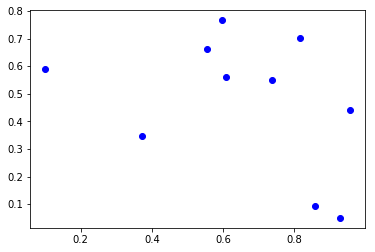

In [2]:
x = np.random.rand(10)
y = np.random.rand(10)
pts = np.asarray([[x[i],y[i]] for i in range(len(x))])
plt.plot(x,y,'bo')
plt.show()

We'll define a cluster as the group of points which are closest to a given center. For now, we'll assume we're given a list of points, the number of clusters we want to create, and the coordinates of the centers of each cluster. We'll then create a list of tuples (a map) for each cluster, containing the coordinates and the index of each point in the pts list.

In [3]:
def cluster(pts,M,cens):
    '''
    assign all data in pts to M clusters with centers cens
    '''
    maps = [[] for _ in range(M)] # [[cluster 1: (pt,#), . . .],[cluster 2: (pt,#), . . .]]
    for i in range(0,len(pts)): # loop over points
        for j in range(0,len(cens)): # loop over centers
            diff = la.norm(pts[i] - cens[j]) # norm of diff btwn point and center
            if j==0: # first center is always "closest" to pt
                cnt = 0
                old_diff = diff
            elif abs(diff) < old_diff: # see if other centers are closer
                cnt = j # if so, store the pt map
                old_diff = diff # and keep track of the smallest diff
        maps[cnt].append((pts[i],i)) # store the actual point, and its "number" in the list
    return np.asarray(maps)

## 2. Optimizing a cluster
Now we can cluster our points according to their norm difference from our cluster centers. Note that this procedure is completely general, no matter the dimensionality of our space.
Next, we need to update this to find _better_ clustering. We'll do this by defining new centers at the vector-mean of the points within a cluster.

In [4]:
def recenter(M,maps):
    '''
    Number of centers M
    Cluster->point maps
    '''
    new_cens = []
    for cen in range(0,M):
        cluster = [x[0] for x in maps[cen]] # grab coordinates of the cluster points
        new_cen = np.mean([x[0] for x in maps[cen]],axis=0) # take the mean of these points
        new_cens.append(new_cen) # save the new center
    return np.asarray(new_cens)

## 3. The k-means algorithm
After taking a given clustering and re-calculating the centers, we can then re-cluster our points and repeat. We will start by placing the centers on random data points, then iterate the re-clustering until the centers are no longer changing.

In [5]:
def k_means(pts,M,save=False):
    '''
    List of initial data points pts
    Number of centers M
    Option to save all of the maps and centers for diagnostics
    '''
    points = random.sample(range(0,len(pts)),M) # grab some random points
    cens = np.asarray([pts[points[i]] for i in range(0,M)]) # initial centers on random points
    maps = cluster(pts,M,cens) # make initial cluster
    all_maps = [maps] # save all of the maps for diagnostics 
    all_cens = [cens] # save all of the cens for diagnostics

    diffs = [1] # ensure one loop
    while max(diffs) > 0:
        new_cens = recenter(M,maps) # make new centers from clusters
        maps = cluster(pts,M,new_cens) # make new clusters from centers
        all_maps.append(maps) # save the map
        all_cens.append(new_cens) # save the cens
    
        diffs = [np.mean(cens[i] - new_cens[i]) for i in range(0,len(new_cens))]
        diffs = np.absolute(diffs) # check if centers have moved
        cens = new_cens # update the centers and repeat
    if save:
        return np.asarray(maps), all_maps, all_cens
    else:
        return np.asarray(maps)

Great! Let's run the algorithm once, and see if the centers are updating properly.

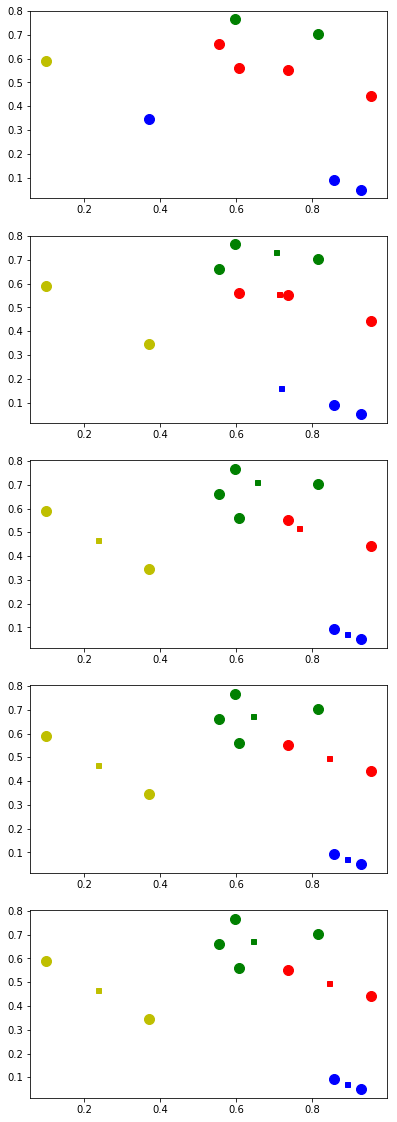

In [6]:
M = 4
maps, all_maps, all_cens = k_means(pts,M,True)

color_list = ['b','r','g','y']
fig, axs = plt.subplots(len(all_maps), sharey=True,figsize=(6.4,20))
fig.set_facecolor('white')
axs = axs.ravel()
for i in range(0,len(all_maps)): # go over each iteration and graph them
    for j in range(0,M): # graph each center in a separate color
        xvals = [all_maps[i][j][k][0][0] for k in range(0,len(all_maps[i][j]))]
        yvals = [all_maps[i][j][k][0][1] for k in range(0,len(all_maps[i][j]))]
        cenx = [all_cens[i][j][0]]
        ceny = [all_cens[i][j][1]]
        axs[i].plot(xvals,yvals,color_list[j] + 'o',markersize=10)
        axs[i].plot(cenx,ceny,color_list[j] + 's',markersize=5)

## 4. Finding the best cluster
The results of this, of course, depend on the randomly chosen starting centers. It would be helpful to define an error metric which determines how "tight" the clustering is- the standard deviation of the mean point-cluster difference should suffice for this purpose.

In [7]:
def cen_err(maps):
    '''
    Take in the center->point map
    Return the stddv of the mean center->point diffs
    '''
    errors = []
    for i in range(0,len(maps)): # loop over centers
        cen = np.mean([c[0] for c in maps[i]],axis=0) # mean of coords in center i
        diffs = [] # hold diffs for center i
        for j in range(0,len(maps[i])): # loop over points
            diffs.append(la.norm(maps[i][j][0] - cen)) # norm of diff btwn point and cen
        errors.append(np.mean(diffs)) # store the mean error for center i
    return np.std(errors)

Since the clustering depends on the initial random points, we can simply run the algorithm many times and pick the best clustering. Let's see what different clusters the algorithm comes up with!

[0.06651887074739073, 0.05421467370140601, 0.05145910132741553, 0.05421467370140601, 0.09792879989893875, 0.07141919561483859, 0.05421467370140601, 0.05421467370140601, 0.04720595984079389, 0.05421467370140601]


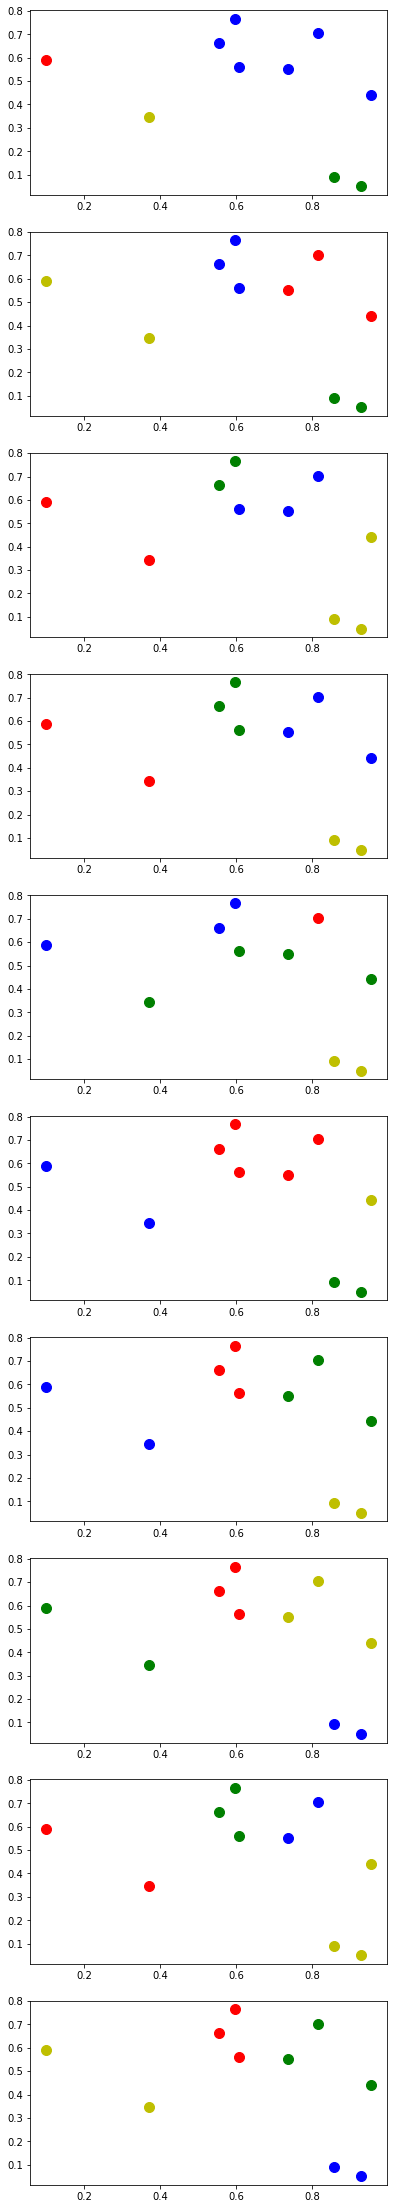

In [8]:
maps_list = []
errors = []
for i in range(0,10):
    maps = k_means(pts,M)
    maps_list.append(maps)
    errors.append(cen_err(maps))
best = np.argmin(errors)

fig, axs = plt.subplots(len(maps_list), sharey=True,figsize=(6.4,40))
axs = axs.ravel()
for i in range(0,len(maps_list)): # graph every run of k-means
    for j in range(0,M): # graph each center in a separate color
        xvals = [maps_list[i][j][k][0][0] for k in range(0,len(maps_list[i][j]))]
        yvals = [maps_list[i][j][k][0][1] for k in range(0,len(maps_list[i][j]))]
        axs[i].plot(xvals,yvals,color_list[j] + 'o',markersize=10)
print(errors)

Now we have many different clusters to choose from. Which one is the best?

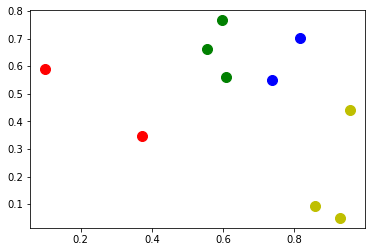

In [9]:
for j in range(0,M): # graph each center in a separate color
    xvals = [maps_list[best][j][k][0][0] for k in range(0,len(maps_list[best][j]))]
    yvals = [maps_list[best][j][k][0][1] for k in range(0,len(maps_list[best][j]))]
    plt.plot(xvals,yvals,color_list[j] + 'o',markersize=10)
plt.show()